In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import json

# Local imports
from src.data_processing.lstm_data_preprocessing import reduce_time_bucket_features, FeaturesConfig, TimeBucketConfig
from src.data_processing.loader import load_time_bucket_data

2025-04-17 18:01:57.857373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744909318.006107   13154 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744909318.043518   13154 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744909318.231155   13154 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744909318.231194   13154 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744909318.231196   13154 computation_placer.cc:177] computation placer alr

In [3]:
# Load the model and details on configurations used to train the model like the time bucket data used and the features used

# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

model_folder = "../model_generation/trained_models/lstm_3"
model = load_model(os.path.join(model_folder, "model.keras"),
    custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
with open(os.path.join(model_folder, "config.json"), 'r') as f:
    configs = json.load(f)

features_config = FeaturesConfig(**configs["features_config"])
time_bucket_folder = configs["time_bucket_folder"]
test_size = configs["test_size"]

I0000 00:00:1744909322.753223   13154 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9


In [4]:
# Get the train test data set used to train the model were testing

X_scaler = StandardScaler()
y_scaler = StandardScaler()

token_time_buckets, time_bucket_config = load_time_bucket_data(time_bucket_folder)

token_datasets = []
for token_address, data in token_time_buckets.items():
    X = data["X"]
    y = data["y"]
    bucket_times = data["bucket_times"]

    # Only get the features listed in features_config
    X = reduce_time_bucket_features(X, features_config)

    token_datasets.append((X, y, token_address, bucket_times))

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)

In [5]:
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

I0000 00:00:1744909336.112329   13262 cuda_dnn.cc:529] Loaded cuDNN version 90300


523/523 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step


In [6]:
from visualisation_methods import plot_error_distribution, plot_directional_accuracy, plot_prediction_vs_actual

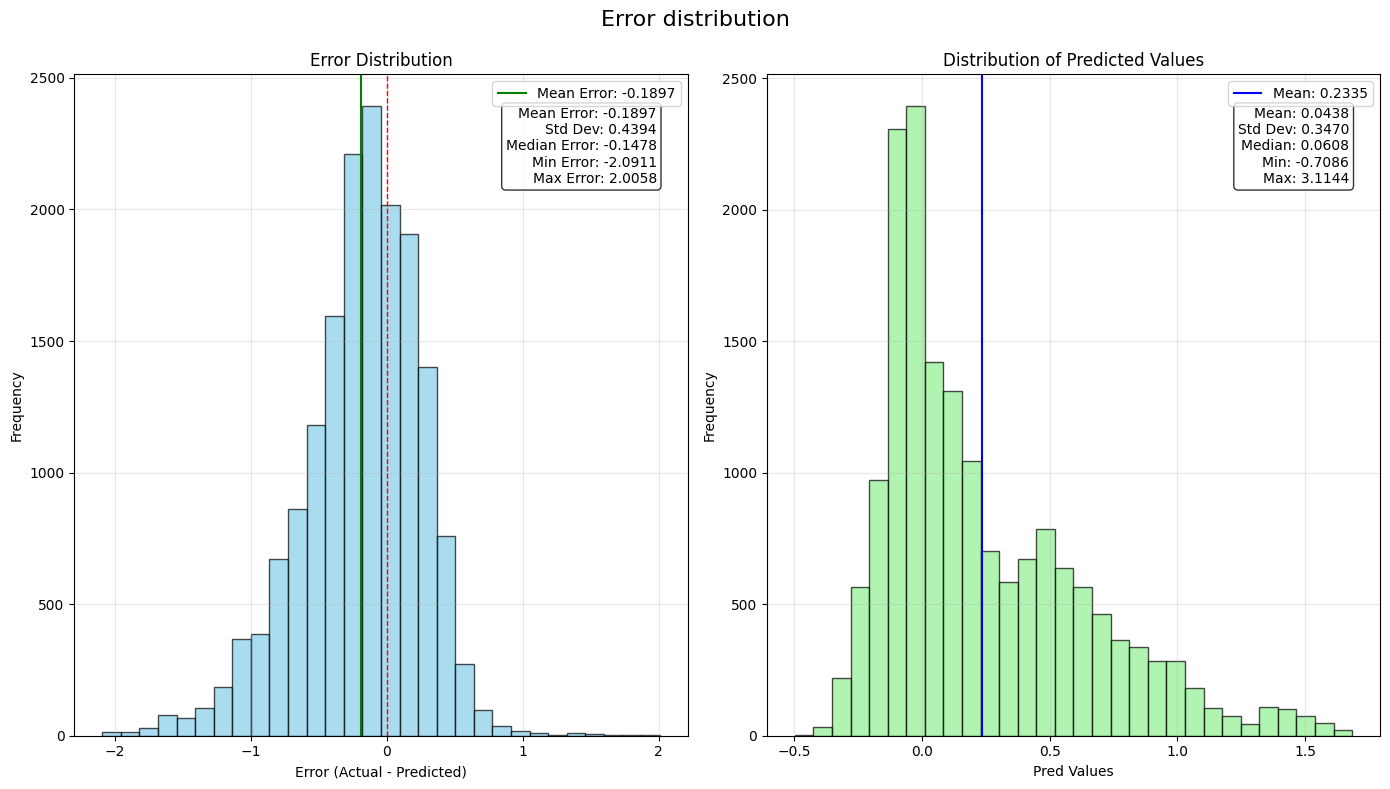

In [7]:
plot_error_distribution(y_pred_actual, y_test_actual, title="Error distribution")

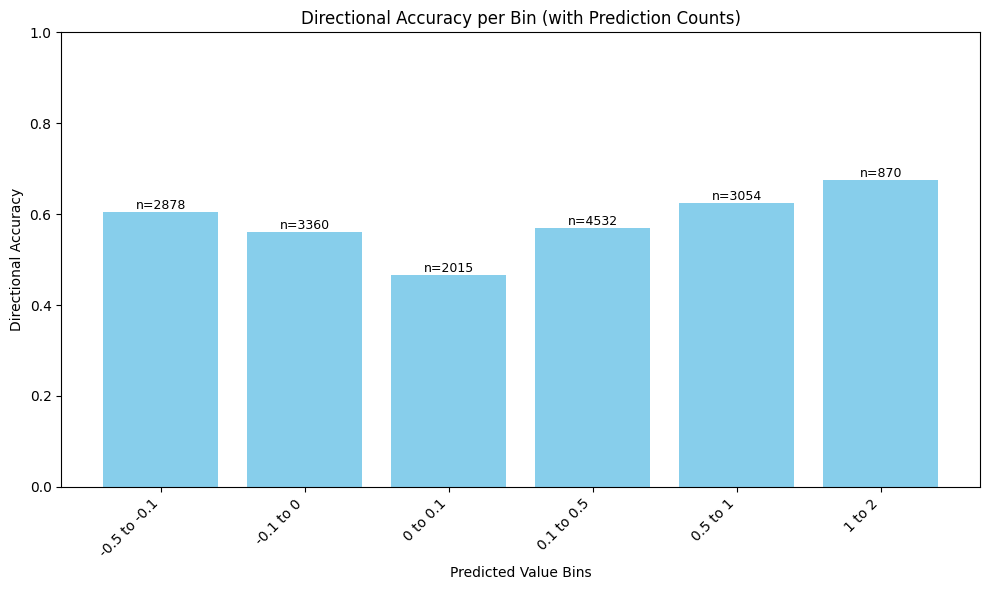

({'-0.5 to -0.1': np.float64(0.6042390548992356),
  '-0.1 to 0': np.float64(0.5601190476190476),
  '0 to 0.1': np.float64(0.4655086848635236),
  '0.1 to 0.5': np.float64(0.5697263901147396),
  '0.5 to 1': np.float64(0.6237721021611002),
  '1 to 2': np.float64(0.674712643678161)},
 {'-0.5 to -0.1': np.int64(2878),
  '-0.1 to 0': np.int64(3360),
  '0 to 0.1': np.int64(2015),
  '0.1 to 0.5': np.int64(4532),
  '0.5 to 1': np.int64(3054),
  '1 to 2': np.int64(870)})

In [8]:
bins = [-np.inf, -8, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, 8, np.inf]
plot_directional_accuracy(y_pred_actual, y_test_actual, bins=bins)

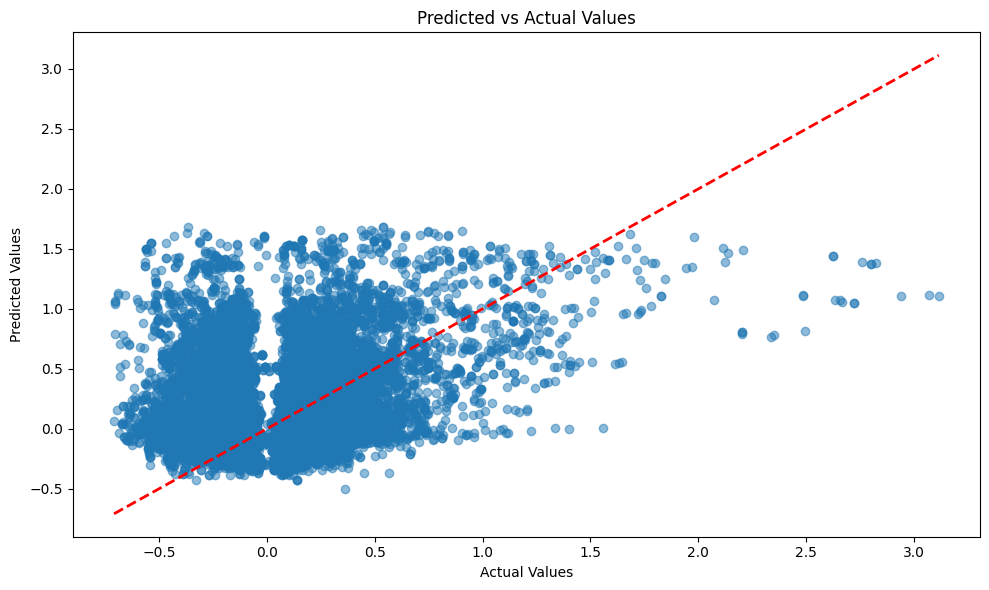

In [9]:
plot_prediction_vs_actual(y_pred_actual, y_test_actual)